# Collaborative Filtering

In [1]:
import logging
from pprint import pprint

import matplotlib.pyplot as plt
# overwriting Recorder callback with custom plot_loss
from fastai import learner
from fastai.collab import *
from fastai.collab import (EarlyStoppingCallback, EmbeddingDotBias, Learner,
                           MSELossFlat, default_device)
from fastai.tabular.all import *

import vaep
import vaep.model
import vaep.models as models
import vaep.nb
from vaep.io import datasplits
from vaep.logging import setup_logger
from vaep.models import RecorderDump, plot_loss

learner.Recorder.plot_loss = plot_loss
# import fastai.callback.hook # Learner.summary


logger = setup_logger(logger=logging.getLogger('vaep'))
logger.info(
    "Experiment 03 - Analysis of latent spaces and performance comparisions")

figures = {}  # collection of ax or figures

vaep - INFO     Experiment 03 - Analysis of latent spaces and performance comparisions


Papermill script parameters:

In [2]:
# catch passed parameters
args = None
args = dict(globals()).keys()

In [3]:
# files and folders
# Datasplit folder with data for experiment
folder_experiment: str = 'runs/example'
folder_data: str = ''  # specify data directory if needed
file_format: str = 'csv'  # change default to pickled files
# training
epochs_max: int = 20  # Maximum number of epochs
# early_stopping:bool = True # Wheather to use early stopping or not
patience: int = 1  # Patience for early stopping
batch_size: int = 32_768  # Batch size for training (and evaluation)
cuda: bool = True  # Use the GPU for training?
# model
# Dimensionality of encoding dimension (latent space of model)
latent_dim: int = 10
# hidden_layers:str = '128_64' # Underscore separated string of layers, '128 64' for the encoder, reversed for decoder
sample_idx_position: int = 0  # position of index which is sample ID
model: str = 'CF'  # model name
model_key: str = 'CF'  # potentially alternative key for model (grid search)
save_pred_real_na: bool = True  # Save all predictions for missing values

In [4]:
# Parameters
model = "CF"
latent_dim = 50
batch_size = 1024
epochs_max = 100
sample_idx_position = 0
cuda = False
save_pred_real_na = True
fn_rawfile_metadata = "https://raw.githubusercontent.com/RasmussenLab/njab/HEAD/docs/tutorial/data/alzheimer/meta.csv"
folder_experiment = "runs/alzheimer_study"
model_key = "CF"


Some argument transformations

In [5]:
args = vaep.nb.get_params(args, globals=globals())
args

{'folder_experiment': 'runs/alzheimer_study',
 'folder_data': '',
 'file_format': 'csv',
 'epochs_max': 100,
 'patience': 1,
 'batch_size': 1024,
 'cuda': False,
 'latent_dim': 50,
 'sample_idx_position': 0,
 'model': 'CF',
 'model_key': 'CF',
 'save_pred_real_na': True,
 'fn_rawfile_metadata': 'https://raw.githubusercontent.com/RasmussenLab/njab/HEAD/docs/tutorial/data/alzheimer/meta.csv'}

In [6]:
args = vaep.nb.args_from_dict(args)

# # Currently not needed -> DotProduct used, not a FNN
# if isinstance(args.hidden_layers, str):
#     args.overwrite_entry("hidden_layers", [int(x) for x in args.hidden_layers.split('_')])
# else:
#     raise ValueError(f"hidden_layers is of unknown type {type(args.hidden_layers)}")
args

{'batch_size': 1024,
 'cuda': False,
 'data': Path('runs/alzheimer_study/data'),
 'epochs_max': 100,
 'file_format': 'csv',
 'fn_rawfile_metadata': 'https://raw.githubusercontent.com/RasmussenLab/njab/HEAD/docs/tutorial/data/alzheimer/meta.csv',
 'folder_data': '',
 'folder_experiment': Path('runs/alzheimer_study'),
 'latent_dim': 50,
 'model': 'CF',
 'model_key': 'CF',
 'out_figures': Path('runs/alzheimer_study/figures'),
 'out_folder': Path('runs/alzheimer_study'),
 'out_metrics': Path('runs/alzheimer_study'),
 'out_models': Path('runs/alzheimer_study'),
 'out_preds': Path('runs/alzheimer_study/preds'),
 'patience': 1,
 'sample_idx_position': 0,
 'save_pred_real_na': True}

Some naming conventions

In [7]:
TEMPLATE_MODEL_PARAMS = 'model_params_{}.json'

if not args.cuda:
    default_device(use=False)  # set to cpu

## Load data in long format

In [8]:
data = datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


data is loaded in long format

In [9]:
data.train_X

Sample ID   protein groups                                                                
Sample_000  A0A024QZX5;A0A087X1N8;P35237                                                     15.912
            A0A024R0T9;K7ER74;P02655                                                         16.852
            A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8   15.570
            A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503                                          16.481
            A0A075B6H7                                                                       17.301
                                                                                              ...  
Sample_209  Q9Y6R7                                                                           19.275
            Q9Y6X5                                                                           15.732
            Q9Y6Y8;Q9Y6Y8-2                                                                  19.577
         

In [10]:
# ! add check that specified data is available
# silent error in fastai if e.g. target column is not available

Infer index names from long format

In [11]:
index_columns = list(data.train_X.index.names)
sample_id = index_columns.pop(args.sample_idx_position)
if len(index_columns) == 1:
    index_column = index_columns.pop()
    index_columns = None
    logger.info(f"{sample_id = }, single feature: {index_column = }")
else:
    logger.info(f"{sample_id = }, multiple features: {index_columns = }")

if not index_columns:
    index_columns = [sample_id, index_column]
else:
    raise NotImplementedError(
        "More than one feature: Needs to be implemented. see above logging output.")

vaep - INFO     sample_id = 'Sample ID', single feature: index_column = 'protein groups'


### Use some simulated missing for evaluation

The validation simulated NA is used to by all models to evaluate training performance.

In [12]:
val_pred_simulated_na = data.val_y.to_frame(name='observed')
val_pred_simulated_na

,,observed
Sample ID,protein groups,
Sample_158,Q9UN70;Q9UN70-2,14.630
Sample_050,Q9Y287,15.755
Sample_107,Q8N475;Q8N475-2,15.029
Sample_199,P06307,19.376
Sample_067,Q5VUB5,15.309
...,...,...
Sample_111,F6SYF8;Q9UBP4,22.822
Sample_002,A0A0A0MT36,18.165
Sample_049,Q8WY21;Q8WY21-2;Q8WY21-3;Q8WY21-4,15.525


In [13]:
test_pred_simulated_na = data.test_y.to_frame(name='observed')
test_pred_simulated_na.describe()

,observed
count,"12,600.000"
mean,16.339
std,2.741
min,7.209
25%,14.412
50%,15.935
75%,17.910
max,30.140


## Collaborative Filtering

- save custom collab batch size (increase AE batch size by a factor), could be setup separately.
- the test data is used to evaluate the performance after training

In [14]:
# larger mini-batches speed up training
ana_collab = models.collab.CollabAnalysis(
    datasplits=data,
    sample_column=sample_id,
    item_column=index_column,  # not generic
    target_column='intensity',
    model_kwargs=dict(n_factors=args.latent_dim,
                      y_range=(int(data.train_X.min()),
                               int(data.train_X.max()) + 1)
                      ),
    batch_size=args.batch_size)

In [15]:
print("Args:")
pprint(ana_collab.model_kwargs)

Args:
{'n_factors': 50, 'y_range': (7, 31)}


In [16]:
ana_collab.model = EmbeddingDotBias.from_classes(
    classes=ana_collab.dls.classes,
    **ana_collab.model_kwargs)

args.n_params = models.calc_net_weight_count(ana_collab.model)
ana_collab.params['n_parameters'] = args.n_params
ana_collab.learn = Learner(dls=ana_collab.dls, model=ana_collab.model, loss_func=MSELossFlat(),
                           cbs=EarlyStoppingCallback(patience=args.patience),
                           model_dir=args.out_models)
if args.cuda:
    ana_collab.learn.model = ana_collab.learn.model.cuda()
else:
    # try to set explicitly cpu in case not cuda
    # MPS logic might not work properly in fastai yet https://github.com/fastai/fastai/pull/3858
    ana_collab.learn.model = ana_collab.learn.model.cpu()

# learn.summary() # see comment at DAE

### Training

suggested_lr.valley = 0.00525


epoch,train_loss,valid_loss,time
0,8.187933,11.897199,00:01
1,4.106548,5.451025,00:01
2,1.185384,1.551401,00:01
3,0.642876,0.817062,00:01
4,0.563023,0.737749,00:01
5,0.558378,0.731094,00:01
6,0.531439,0.692058,00:01
7,0.442223,0.603942,00:01
8,0.395300,0.548008,00:01
9,0.364038,0.522350,00:01


No improvement since epoch 12: early stopping


vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/figures/collab_training


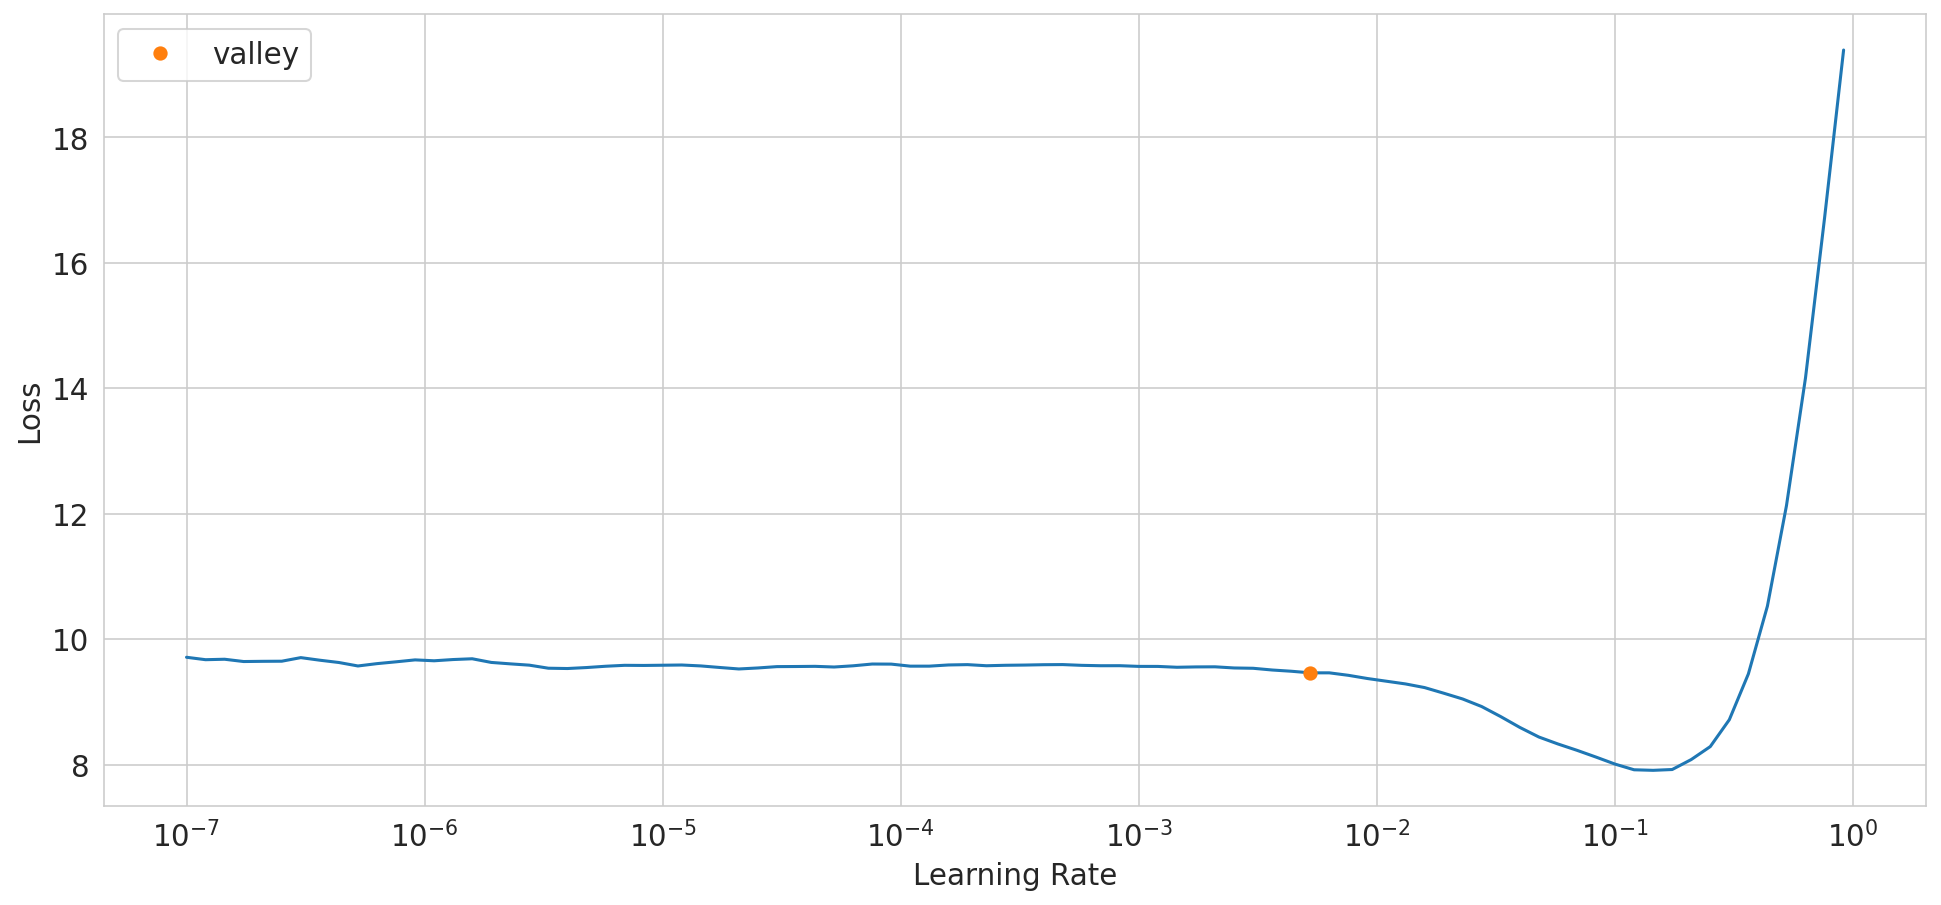

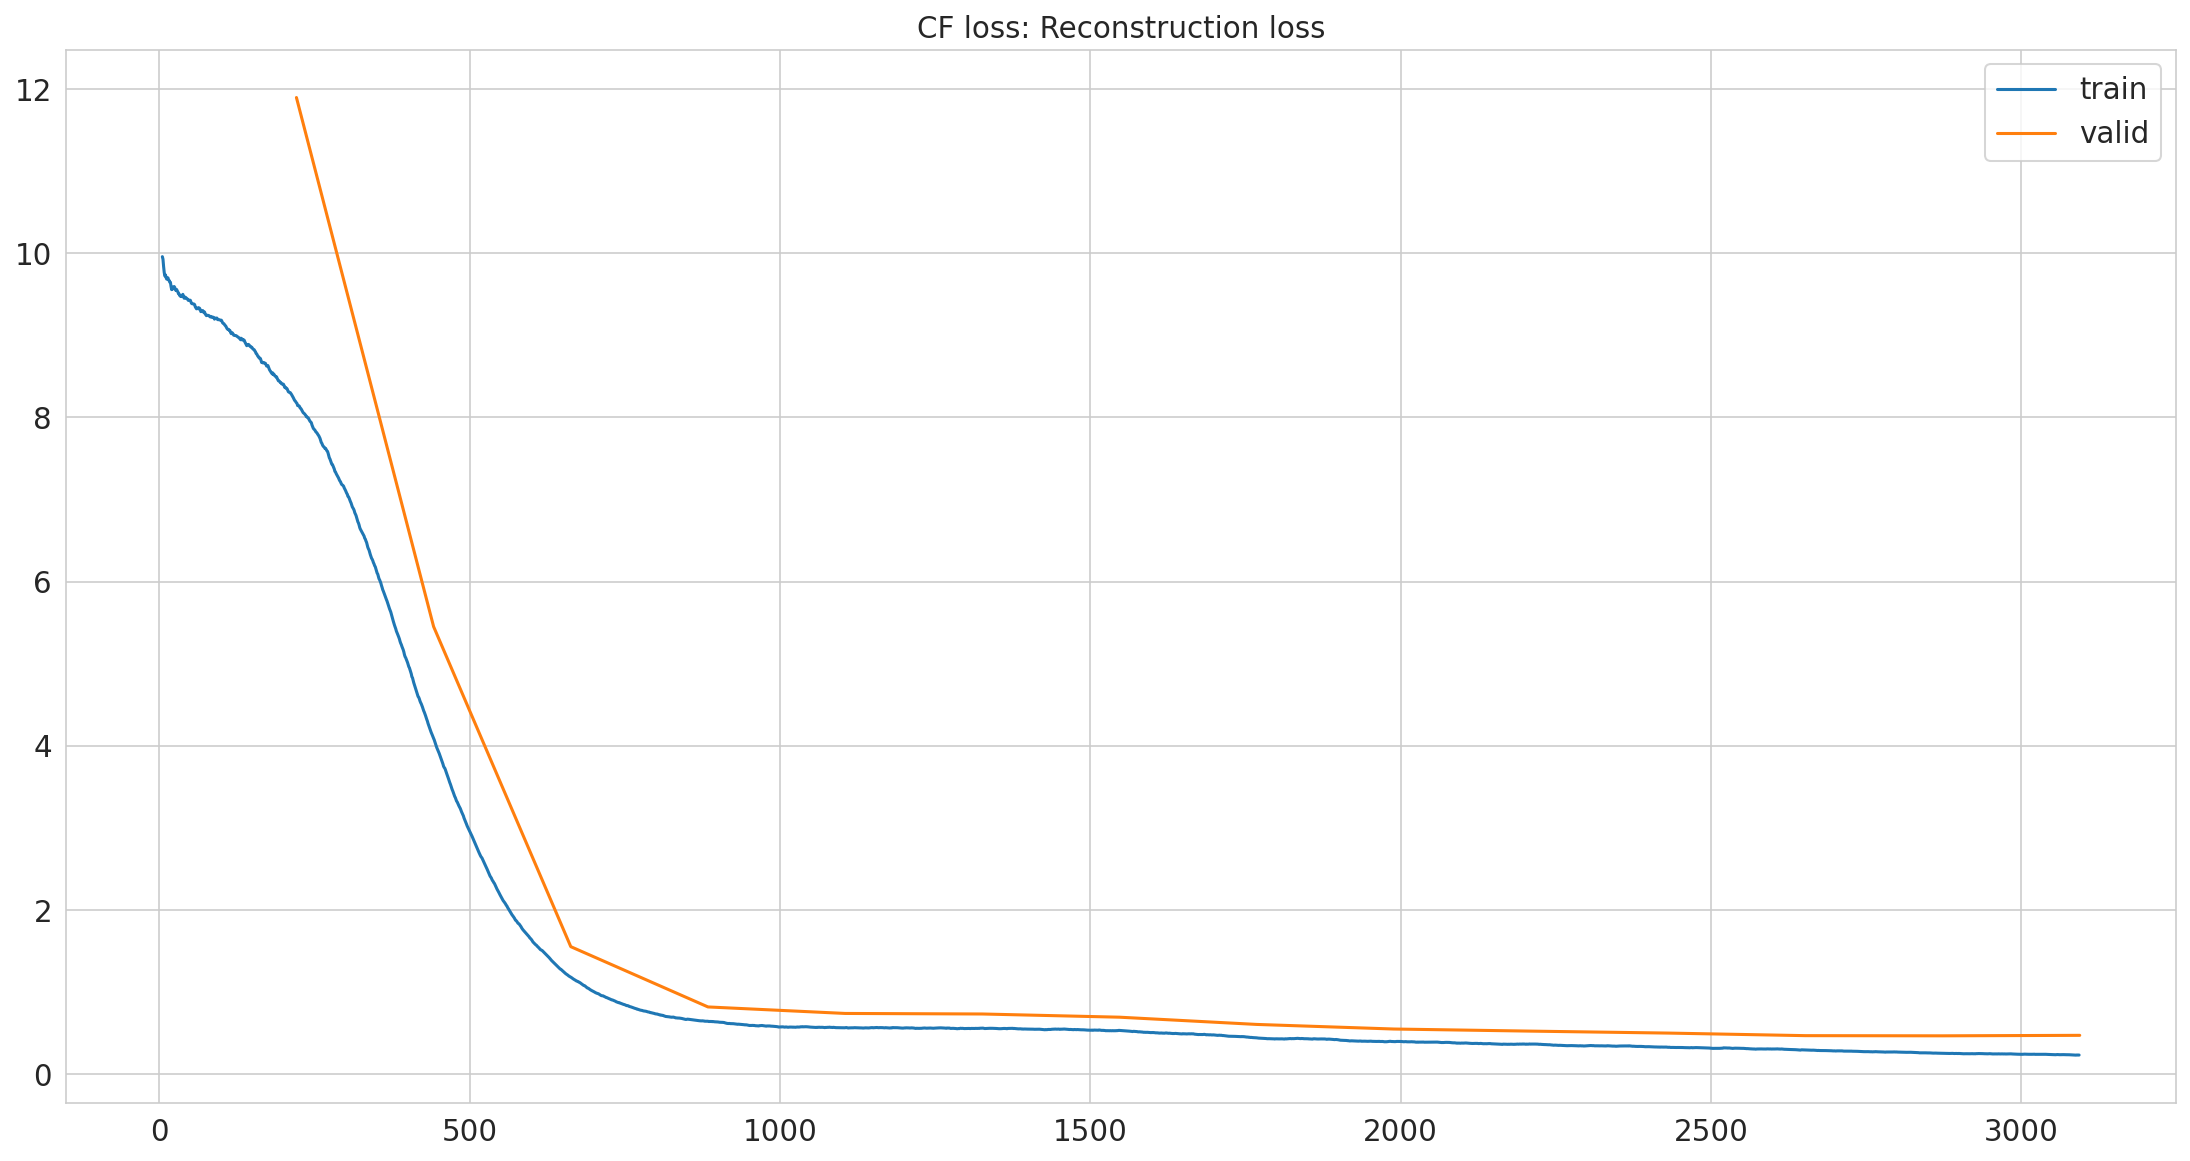

In [17]:
# papermill_description=train_collab
suggested_lr = ana_collab.learn.lr_find()
print(f"{suggested_lr.valley = :.5f}")
ana_collab.learn.fit_one_cycle(args.epochs_max, lr_max=suggested_lr.valley)
args.epoch_trained = ana_collab.learn.epoch + 1
# ana_collab.learn.fit_one_cycle(args.epochs_max, lr_max=1e-3)
ana_collab.model_kwargs['suggested_inital_lr'] = suggested_lr.valley
ana_collab.learn.save('collab_model')
fig, ax = plt.subplots(figsize=(15, 8))
ax.set_title('CF loss: Reconstruction loss')
ana_collab.learn.recorder.plot_loss(skip_start=5, ax=ax)
recorder_dump = RecorderDump(
    recorder=ana_collab.learn.recorder, name='CF')
recorder_dump.save(args.out_figures)
del recorder_dump
vaep.savefig(fig, name='collab_training',
             folder=args.out_figures)
ana_collab.model_kwargs['batch_size'] = ana_collab.batch_size
vaep.io.dump_json(ana_collab.model_kwargs, args.out_models /
                  TEMPLATE_MODEL_PARAMS.format('CF'))

### Predictions

Compare simulated_na data predictions to original values

In [18]:
# this could be done using the validation data laoder now
ana_collab.test_dl = ana_collab.dls.test_dl(
    data.val_y.reset_index())  # test_dl is here validation data
val_pred_simulated_na['CF'], _ = ana_collab.learn.get_preds(
    dl=ana_collab.test_dl)
val_pred_simulated_na

,,observed,CF
Sample ID,protein groups,,
Sample_158,Q9UN70;Q9UN70-2,14.630,15.908
Sample_050,Q9Y287,15.755,16.254
Sample_107,Q8N475;Q8N475-2,15.029,14.053
Sample_199,P06307,19.376,19.474
Sample_067,Q5VUB5,15.309,15.086
...,...,...,...
Sample_111,F6SYF8;Q9UBP4,22.822,22.838
Sample_002,A0A0A0MT36,18.165,16.108
Sample_049,Q8WY21;Q8WY21-2;Q8WY21-3;Q8WY21-4,15.525,15.898


select test data predictions

In [19]:
ana_collab.test_dl = ana_collab.dls.test_dl(data.test_y.reset_index())
test_pred_simulated_na['CF'], _ = ana_collab.learn.get_preds(dl=ana_collab.test_dl)
test_pred_simulated_na

observed  \
Sample ID  protein groups                                                        
Sample_000 A0A075B6P5;P01615                                            17.016   
           A0A087X089;Q16627;Q16627-2                                   18.280   
           A0A0B4J2B5;S4R460                                            21.735   
           A0A140T971;O95865;Q5SRR8;Q5SSV3                              14.603   
           A0A140TA33;A0A140TA41;A0A140TA52;P22105;P22105-3;P22105-4    16.143   
...                                                                        ...   
Sample_209 Q96ID5                                                       16.074   
           Q9H492;Q9H492-2                                              13.173   
           Q9HC57                                                       14.207   
           Q9NPH3;Q9NPH3-2;Q9NPH3-5                                     14.962   
           Q9UGM5;Q9UGM5-2                                              16.871   

                                                                         CF  
Sample ID  protein groups                                                    
Sample_000 A0A075B6P5;P01615                                         17.157  
           A0A087X089;Q16627;Q16627-2                                17.886  
           A0A0B4J2B5;S4R460                                         22.660  
           A0A140T971;O95865;Q5SRR8;Q5SSV3                           15.474  
           A0A140TA33;A0A140TA41;A0A140TA52;P22105;P22105-3;P22105-4 16.391  
...                                                                     ...  
Sample_209 Q96ID5                                                    15.933  
           Q9H492;Q9H492-2                                           13.276  
           Q9HC57                                                    14.137  
           Q9NPH3;Q9NPH3-2;Q9NPH3-5                                  15.745  
           Q9UGM5;Q9UGM5-2                                           16.452  

[12600 rows x 2 columns]

In [20]:
if args.save_pred_real_na:
    pred_real_na = models.collab.get_missing_values(
        df_train_long=data.train_X,
        val_idx=data.val_y.index,
        test_idx=data.test_y.index,
        analysis_collab=ana_collab)
    pred_real_na.to_csv(args.out_preds / f"pred_real_na_{args.model_key}.csv")

## Data in wide format

- Autoencoder need data in wide format

In [21]:
data.to_wide_format()
args.M = data.train_X.shape[-1]
data.train_X.head()

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,NaN,15.050,16.842,NaN,NaN,19.563,NaN,12.805
Sample_001,NaN,16.874,15.519,16.387,NaN,19.941,18.786,17.144,NaN,19.067,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,NaN,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,NaN,12.445
Sample_004,15.603,15.331,15.375,16.679,NaN,20.450,18.682,17.081,14.140,19.686,...,14.757,NaN,NaN,15.256,17.075,19.582,15.328,NaN,13.145,NaN


### Validation data

- all measured (identified, observed) peptides in validation data

> Does not make to much sense to compare collab and AEs,
> as the setup differs of training and validation data differs

In [22]:
# papermill_description=metrics
d_metrics = models.Metrics()

The simulated NA for the validation step are real test data (not used for training nor early stopping)

In [23]:
added_metrics = d_metrics.add_metrics(val_pred_simulated_na, 'valid_simulated_na')
added_metrics

Selected as truth to compare to: observed


{'CF': {'MSE': 0.47102065230441137,
  'MAE': 0.46391809307722637,
  'N': 12600,
  'prop': 1.0}}

### Test Datasplit

Simulated NAs : Artificially created NAs. Some data was sampled and set
explicitly to misssing before it was fed to the model for
reconstruction.

In [24]:
added_metrics = d_metrics.add_metrics(test_pred_simulated_na, 'test_simulated_na')
added_metrics

Selected as truth to compare to: observed


{'CF': {'MSE': 0.49550544469873453,
  'MAE': 0.4688477958998151,
  'N': 12600,
  'prop': 1.0}}

Save all metrics as json

In [25]:
vaep.io.dump_json(d_metrics.metrics, args.out_metrics /
                  f'metrics_{args.model_key}.json')

In [26]:
metrics_df = models.get_df_from_nested_dict(
    d_metrics.metrics, column_levels=['model', 'metric_name']).T
metrics_df

subset             valid_simulated_na  test_simulated_na
model metric_name                                       
CF    MSE                       0.471              0.496
      MAE                       0.464              0.469
      N                    12,600.000         12,600.000
      prop                      1.000              1.000

## Save predictions

In [27]:
# save simulated missing values for both splits
val_pred_simulated_na.to_csv(args.out_preds / f"pred_val_{args.model_key}.csv")
test_pred_simulated_na.to_csv(args.out_preds / f"pred_test_{args.model_key}.csv")

## Config

In [28]:
args.dump(fname=args.out_models / f"model_config_{args.model_key}.yaml")
args

{'M': 1421,
 'batch_size': 1024,
 'cuda': False,
 'data': Path('runs/alzheimer_study/data'),
 'epoch_trained': 14,
 'epochs_max': 100,
 'file_format': 'csv',
 'fn_rawfile_metadata': 'https://raw.githubusercontent.com/RasmussenLab/njab/HEAD/docs/tutorial/data/alzheimer/meta.csv',
 'folder_data': '',
 'folder_experiment': Path('runs/alzheimer_study'),
 'latent_dim': 50,
 'model': 'CF',
 'model_key': 'CF',
 'n_params': 83283,
 'out_figures': Path('runs/alzheimer_study/figures'),
 'out_folder': Path('runs/alzheimer_study'),
 'out_metrics': Path('runs/alzheimer_study'),
 'out_models': Path('runs/alzheimer_study'),
 'out_preds': Path('runs/alzheimer_study/preds'),
 'patience': 1,
 'sample_idx_position': 0,
 'save_pred_real_na': True}